# Create imputation error plots by SNP & by sample

In [1]:
using Revise
using VCFTools
using MendelImpute
using GeneticVariation
using Random
using StatsBase
using CodecZlib
using ProgressMeter
using JLSO
using BenchmarkTools
using GroupSlices
using LinearAlgebra
# using ProfileView

BLAS.set_num_threads(1)

In [2]:
# 8 threads, d = 1000
Random.seed!(2020)
tgtfile = "target.chr20.typedOnly.maf0.4.masked.vcf.gz"
reffile = "ref.chr20.excludeTarget.maxd1000.jlso"
outfile = "mendel.chr20.imputed.vcf.gz"
@time ph = phase(tgtfile, reffile, outfile);

X_complete = convert_gt(UInt8, "target.chr20.full.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")
# rm(outfile, force=true)

Number of threads = 8
Importing reference haplotype data...
Total windows = 867, averaging ~ 424 unique haplotypes per window.

Timings: 
    Data import                     = 11.8698 seconds
        import target data             = 2.07733 seconds
        import compressed haplotypes   = 9.79245 seconds
    Computing haplotype pair        = 5.34651 seconds
        BLAS3 mul! to get M and N      = 0.0697326 seconds per thread
        haplopair search               = 0.987181 seconds per thread
        initializing missing           = 0.0042913 seconds per thread
        allocating and viewing         = 0.00931544 seconds per thread
        index conversion               = 0.000412627 seconds per thread
    Phasing by win-win intersection = 1.55202 seconds
        Window-by-window intersection  = 0.0520876 seconds per thread
        Breakpoint search              = 0.329749 seconds per thread
        Recording result               = 0.16562 seconds per thread
    Imputation             

In [3]:
using GeneticVariation, Plots
reader = VCF.Reader(openvcf(outfile, "r"))
snpscores = Vector{Float64}(undef, nrecords(outfile))

# loop over SNPs
for (i, record) in enumerate(reader)
    snpscores[i] = parse(Float64, VCF.info(record)[1].second)
end
close(reader)

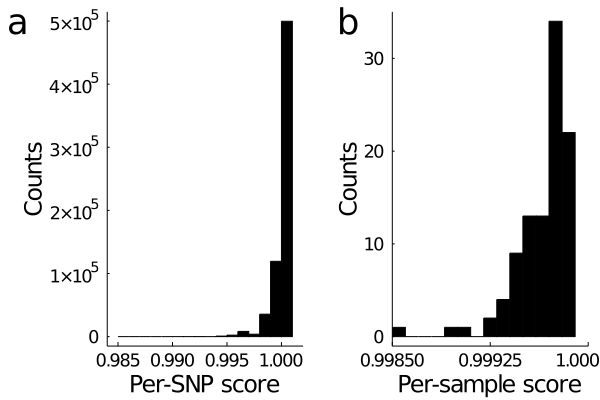

In [56]:
# plot histogram of SNP scores
using StatsPlots, FixedPointNumbers

# snperr = histogram(snpscores, label=:none, xlabel="Per-SNP error", grid=false, 
#     xlim=(0, 0.04), color=:black, ylabel="Counts", bins=20)

snperr = histogram(snpscores, label=:none, xlabel="Per-SNP score", grid=false, 
    color=:black, ylabel="Counts", bins=20, xticks = 0.98:0.005:1.0)

using CSV
quality = CSV.read("mendel.chr20.imputed.sample.error") # import quality score 

Plots.scalefontsizes(1.5)

# visualize error distribution
sampleerr = histogram(quality[:error], label=:none, xlabel="Per-sample score", color=:black,
    grid=false, ylabel="Counts", xlim=(0.9985, 1.0), xticks = range(0.9985, 1.0, length = 3)) 

# combine 2 plots
err_plot = plot(snperr, sampleerr, grid=(2, 1), left_margin = 5Plots.mm)

# add 'A' and 'B' text
fontsize=24
annotate!(err_plot, 0.975, 5*10^5 , text("a", :left, fontsize), subplot=1)
annotate!(err_plot, 0.9981,  34 , text("b", :left, fontsize), subplot=2)

In [55]:
savefig(err_plot, "error.png") # remember to set dpi=300